In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# %matplotlib notebook
%matplotlib inline

# $e^{j\omega_d}=[sin(x[2i])j, cos(x[2i+1])]$

Transformer Positional Encoding uses ```(pe[2i], pe[2i+1])``` pair in an position embedding vector $pe$ to represent a rotating vector $e^{j\omega_d}$ in a complex plane where $d = 2i$. Then, the relative position distance $dt$ is represented as $z^{-dt}$ at each $i$, similar to the signal delay in Z transform where $z = e^{jw_d}$.

<img src="image/transformer_position_encoding.png" align="left" width=600/>

## How Transformer Position Encoding simulates Binary Bit togging


The ```0/1``` togging frequency gets lower as the index in the embedding vector increases. This simulates the togging frequecy in the higher bits of the binary number expression.

<img src="image/transformer_position_encoding_intuition.png" aign="left" width=600/>

In [2]:
B = base = 10000
D = d_model = 512
T = sequence_length = 512
d = dim_indices = np.arange(0, 512)

## Denominator of the position parameter

Denominator exponentially increases as the even dimension ```d=2i``` increases.

$$C ^{ \frac {2i} {D} }$$


In [3]:
def get_denominator(d_model: int = D, base: int = B):
    """
    Args:
        d_model: embedding dimensions
        base: denominator base
    """
    indices = np.arange(0, d_model/2)
    return np.power(base, 2 * indices / d_model)

In [4]:
get_denominator().shape

(256,)

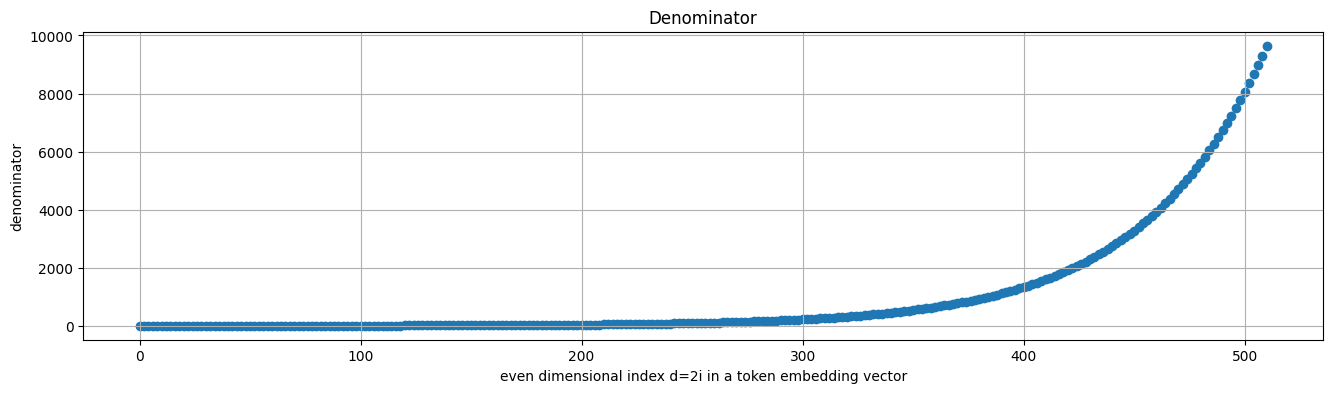

In [18]:
plt.figure(figsize=(16, 4))
plt.xlabel("even dimensional index d=2i in a token embedding vector")
plt.ylabel("denominator")

# y is at i where 2i=d_model
y = get_denominator()
# Adjust to i to d=2i
x = range(0, 2*len(y), 2)

plt.scatter(x, y, label="denominator (log scale)")
plt.title("Denominator")
#plt.yscale("log")
plt.grid()

# Frequency $\omega_d$ at dimension $d=2i$

* The frequency $\omega_d$ at dimension $d=2i$ decreases as ```d``` (dimensional position in ```D``` dimensional vector) increases.

$$\omega_d = \frac {1}{C ^{ \frac {2i} {D} }}$$



In [6]:
def get_frequency(d_model: int = D, base: int = B):
    """
    Args:
        d: dimension index d: (0 ... D-1)
        d_model: embedding vector dimensions
        base: denominator base

    Returns: Frequency ω(d)
    """
    return 1 / get_denominator(d_model=d_model, base=base)

In [79]:
(get_frequency()[-1])

0.00010366329284376981

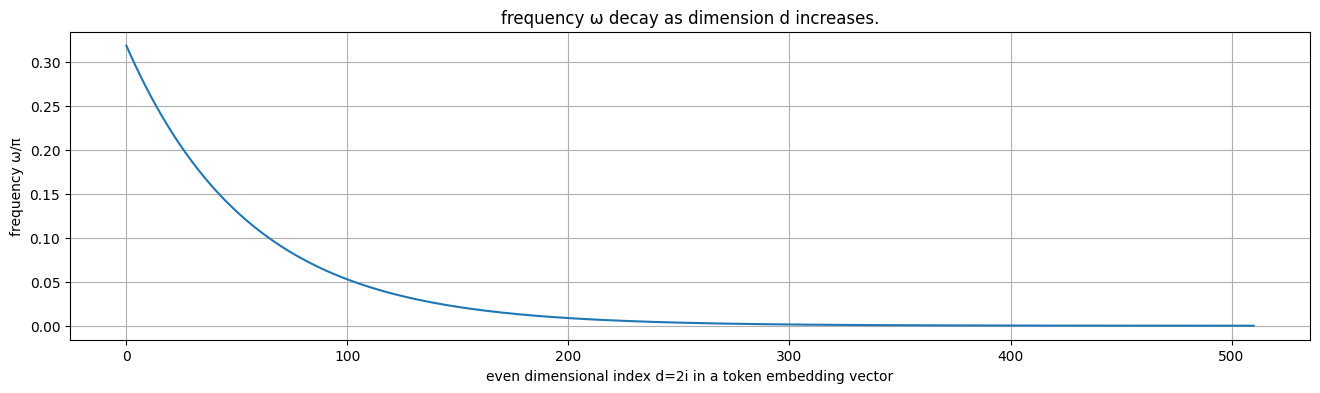

In [20]:
plt.figure(figsize=(16, 4))
y = get_frequency()
x = range(0, 2*len(y), 2)   # adjust from i to d=2i
plt.plot(x, y / np.pi, label="denominator for ")
plt.title("frequency ω decay as dimension d increases.")
plt.xlabel("even dimensional index d=2i in a token embedding vector")
plt.ylabel("frequency ω/π")
plt.grid()

In [33]:
def encode_position(position: int, d_model: int = D, base: int = B):
    """
    Generate [sin(position * ω * d), cos(possition * ω * d)] pairs for all the 
    **even** dimension positions d=(2i) in d_model where i = 0, 1, ... d_model/2.

    Remember the Euler formula exp(jω) = cos(ω) + j(sin(ω)) of a vector rotating at
    the foundation frequency ω. Positions of the rotating vector at time steps d plots
    exp(jωd) that are integer multiples of the rotation at foundation frequency ω.
    
    The sinosidal encoding pair (sin, cos) is generating the time series steps of the
    vector rotations, and position encoding generates them for the specific position.

    Args:
        position: token position in a time step sequence T
        d_model: embedding vector dimensions
        base: denominator base
        
    Returns: 
        [sin(position * ω * d), cos(possition * ω * d)] pairs for even dimension 
        d = 2i (i=0,1,...,d_model/2).
    """
    encodings = np.zeros((d_model,))    # Embeddings of a position (D,)
    # Even indices
    indices = np.arange(0, d_model, 2)
    encodings[indices] = np.sin(position * get_frequency(d_model=d_model, base=base)) 

    # Odd indices
    indices = np.arange(1, d_model, 2)
    encodings[indices] = np.cos(position * get_frequency(d_model=d_model, base=base)) 

    return encodings

## $e^{jw_d}$

In [67]:
def plot_rotating_vector(real_part, imag_part, omega):
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the real part on the x-axis, imaginary part on the y-axis, and omega on the z-axis
    ax.scatter(real_part, imag_part, omega, label=r'$e^{j\omega_d}$ : d=0,2,...,d_model/2')
    
    # Label axes
    ax.set_xlabel('Real part')
    ax.set_xlim(0, 1)
    ax.set_ylabel('Imaginary part')
    ax.set_ylim(0, 1)
    ax.set_zlabel('ω (Angular Frequency)')
    
    # Show the plot with a legend
    ax.legend()
    plt.show()

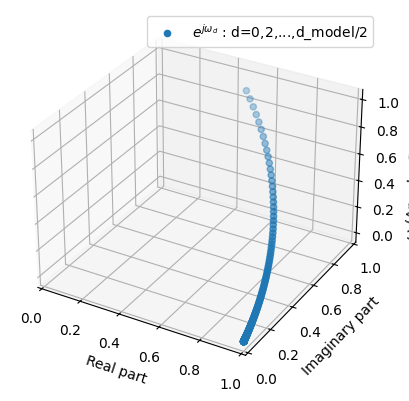

In [68]:
y = encode_position(position=1, d_model=D, base=B)
reals = y[range(1, d_model, 2)]    # cos(ω(d))
imags = y[range(0, d_model, 2)]    # sin(ω(d))
omegas = get_frequency(d_model=D, base=B)
plot_rotating_vector(reals, imags, omegas)

# Position Encodings

In [32]:
def get_positon_encodings(length: int = T, d_model: int = D, base: int = B):
    """Generate the position encodings for all the position in a time step sequence T.
    Args:
        length: length of a time step sequence T
        d_model: embedding dimensions
        base: denominator base        
    """
    position_encodings = np.array([
        encode_position(position=position, d_model=d_model, base=base)
        for position in range(length)    
    ])
    return position_encodings

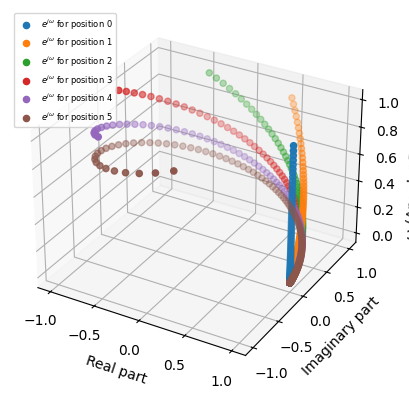

In [56]:
# %matplotlib qt 

position_encodings = get_positon_encodings(length=T, d_model=D, base=B)
imags = position_encodings[:, range(0, d_model, 2)]
reals = position_encodings[:, range(1, d_model, 2)]
omegas = get_frequency(d_model=D, base=B)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the real part on the x-axis, imaginary part on the y-axis, and omega on the z-axis
for pos in range(0, 6, 1):
    # ax.plot(real_part, imag_part, omega, label=r'$e^{j\omega}$')
    ax.scatter(reals[pos:pos+1, :].squeeze(), imags[pos:pos+1, :].squeeze(), omegas, label=r'$e^{j\omega}$'f' for position {pos}')

# Label axes
ax.set_xlabel('Real part')
ax.set_ylabel('Imaginary part')
ax.set_zlabel('ω (Angular Frequency)')

# Show the plot with a legend
ax.legend(loc=2, prop={'size': 6})
plt.show()

# plot_rotating_vector(reals[pos:pos+1, :].squeeze(), imags[pos:pos+1, :].squeeze(), omegas)

In [13]:
position_encodings = get_positon_encodings(length=T, d_model=D, base=B)

<Figure size 2000x300 with 0 Axes>

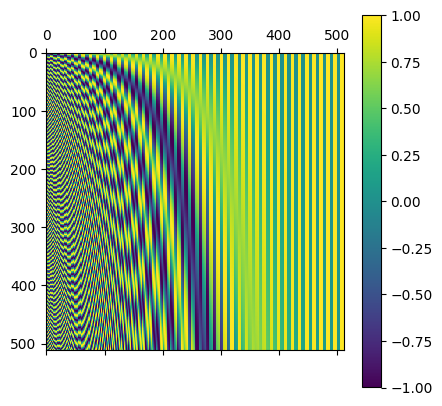

In [14]:
plt.figure(figsize=(20, 3))
cax = plt.matshow(position_encodings)
plt.gcf().colorbar(cax)

$$ω = \frac {1}{C ^{ \frac {2p} {D} }}$$